In [1]:
from collections import defaultdict
import os
import sys 
from tqdm import tqdm
import itertools
import utils.file_utils as utils
sys.path.append("/data/jeff-law/projects/fungcat-function-prediction/src")
#sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__)))))
import fungcat_settings as f_settings
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
from scipy.stats import kruskal, mannwhitneyu
print("python version: %s" % (sys.version.split('\n')[0]))
print("matplotlib version: %s" % (matplotlib.__version__))
print("pandas version: %s" % (pd.__version__))
print("seaborn version: %s" % (sns.__version__))
print("numpy version: %s" % (np.__version__))
print("scipy version: %s" % (scipy.__version__))

python version: 2.7.12 (default, Nov 12 2018, 14:36:49) 
matplotlib version: 2.0.0
pandas version: 0.22.0
seaborn version: 0.7.1
numpy version: 1.14.2
scipy version: 1.1.0


/home/jeffl/.local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
os.chdir("../..")

In [3]:
os.chdir("/data/jeff-law/projects/fungcat-function-prediction/")

In [4]:
alg_name = {'sinksource-squeeze': 'SinkSource Squeeze', 
            'localplus': 'Local+', 'local': 'Local',
#             'localplus': 'Blast Avg.', 'local': 'Local',
            'sinksource': 'SinkSource', 'sinksourceplus': 'SinkSource+',
           'birgrank': 'BirgRank', 'genemania': 'GeneMANIA', 'aptrank': 'AptRank OneWay'}

In [5]:
def get_results(version, exp_names, algorithms, unweighted='', 
                alpha_list=["0_8"], theta_list=[None], mu_list=[None], tol_list=[""],
                ss_alpha="0_8", maxi_list=[], ss_maxi="eps0_0-maxi20", exp_type="ground-truth", verbose=False):
    df_all = pd.DataFrame()
    for exp_name in exp_names:
        loaded = {alg: False for alg in algorithms}
        read_files = set()
        for alg in algorithms:
            if loaded[alg] is True:
                print("Warning! %s being loaded again for %s" % (alg, exp_name))
            # load the results table
            results_dir = "outputs/%s/all/%s/%s" % (version, alg, exp_name)
            for alpha, theta, mu, maxi, tol in itertools.product(*[alpha_list, theta_list, mu_list, maxi_list, tol_list]):
                if tol != "":
                    # tol should only be for genemania
                    if alg != "genemania":
                        continue
                    results_file = "%s/%s%s-%sl0-a%s%s%s.txt" % (
                        results_dir, 'all-sp-' if keep_ann!='' else '', exp_type, unweighted, alpha, maxi, tol)
                elif alg == 'birgrank' and (theta is not None and mu is not None):
                    results_file = "%s/%s%s-%sl0-a%s%s-t%s-m%s%s.txt" % (
                        results_dir, 'all-sp-' if keep_ann!='' else '', exp_type,
                        "swsn-" if 'string' in version and unweighted in ["", "goterm-weight-"] else unweighted, # BirgRank can't use goterm-weight, so don't include it
                        alpha, "-eps0_0001-maxi1000" if maxi != "" else "", 
                        theta, mu, "a0_5" if maxi == "" else "")
#                         results_dir, unweighted, alpha, theta, mu, alpha)
                elif alg == 'aptrank':
                    results_file = "%s/%s%s-%sl0-k8-s5-t0_5-%sa%s%s.txt" % (
                        results_dir, 'all-sp-' if keep_ann!='' else '', exp_type,
                        "swsn-" if unweighted not in ["unw-"] else '', 
                        "oneway", alpha, maxi)
                else:
                    results_file = "%s/%s%s-%sl0-a%s%s.txt" % (
                        results_dir, 'all-sp-' if keep_ann!='' else '', exp_type, unweighted, alpha, maxi)
                if verbose:
                    print("Reading results from %s" % (results_file))
                if not os.path.isfile(results_file):
                    if verbose:
                        print("\tdoesn't exist. Skipping")
                    continue
                if results_file in read_files:
                    # don't read a file twice. This happens to BirgRank if we are using multiple different max_iters
                    continue
                read_files.add(results_file)
                # results_file_template = "%s/groundtruth-l0-a0_8.txt" % (results_dir)
                
                # now read the file
                df = pd.read_csv(results_file, sep='\t', header=[0])
                # and set the name of the algorithm in the dataframe appropriately 
                if alg == "birgrank" and alpha == "0_5" and theta == "0_5" and mu == "0_5":
                    df['Algorithm'] = alg_name[alg]
                    loaded[alg] = True
                elif alg == "birgrank":
                    df['Algorithm'] = 'birgrank a%s t%s m%s' % (alpha, theta, mu)
#                 elif alg == "sinksource" and alpha != "1_0":
                elif alg == "sinksource" and (alpha != ss_alpha or maxi != ss_maxi):
                    df['Algorithm'] = 'sinksource a%s %s' % (alpha, maxi)
#                     print("\t keeping only alpha %s for now" % (ss_alpha))
#                     continue
                else:
                    df['Algorithm'] = alg_name[alg]
                    if verbose:
                        print("%d sp-goterm pairs" % (len(df['Algorithm'])))
                    loaded[alg] = True

#                 print(df.head())
                # I changed '# ann' to be the more correct '# test ann', but am changing it back here to match previous files 
                if '# test ann' in df.columns:
                    df.rename(columns={'# test ann':'# ann'}, inplace=True)
                df_all = pd.concat((df_all, df))
    return df_all

In [6]:
# also read in the prots annotated to each GO term
def parse_pos_neg_file(pos_neg_file, goterms=None):
    print("Reading positive and negative annotations for each protein from %s" % (pos_neg_file))
    goid_prots = {}
    with open(pos_neg_file, 'r') as f:
        for line in f:
            if line[0] == '#':
                continue
            goid, pos_neg_assignment, prots = line.rstrip().split('\t')[:3]
            if goterms and goid not in goterms:
                continue
            prots = set(prots.split(','))
            if int(pos_neg_assignment) == 1:
                goid_prots[goid] = prots
    return goid_prots

def get_species_prot_counts(goid_prots, species_to_uniprot, selected_species=None, goids=None):
    print("Getting annotation counts per species")
    if selected_species is None:
        selected_species = species_to_uniprot.keys()
    if goids is None:
        goids = goid_prots.keys()
    species_prot_counts = {}
    for s in selected_species:
        species_prots = species_to_uniprot[str(int(s))]
        #print("species: %s, %d prots" % (s, len(species_prots)))
#         total_prots = set()
        total_ann = 0
        for goid in goids:
            if goid not in goid_prots:
                continue
            s_prots = goid_prots[goid] & species_prots
#             total_prots.update(s_prots)
            total_ann += len(s_prots)
        species_prot_counts[s] = total_ann
        
    return species_prot_counts

ev_codes = "exp"
pos_neg_files = [
        "inputs/pos-neg/%s/pos-neg-bp-50-list.tsv" % (ev_codes), 
        "inputs/pos-neg/%s/pos-neg-mf-50-list.tsv" % (ev_codes),
]
exp_goid_prots = {}
for pos_neg_file in pos_neg_files:
    exp_goid_prots.update(parse_pos_neg_file(pos_neg_file))
    

# ev_codes = "rem-neg-iea"
ev_codes = "comp"
pos_neg_files = [
        "inputs/pos-neg/%s/pos-neg-bp-5-list.tsv" % (ev_codes), 
        "inputs/pos-neg/%s/pos-neg-mf-5-list.tsv" % (ev_codes),
]
comp_goid_prots = {}
for pos_neg_file in pos_neg_files:
    comp_goid_prots.update(parse_pos_neg_file(pos_neg_file))

ev_codes = "iea"
pos_neg_files = [
        "inputs/pos-neg/%s/pos-neg-bp-10-list.tsv" % (ev_codes), 
        "inputs/pos-neg/%s/pos-neg-mf-10-list.tsv" % (ev_codes),
]
iea_goid_prots = {}
for pos_neg_file in pos_neg_files:
    iea_goid_prots.update(parse_pos_neg_file(pos_neg_file))

Reading positive and negative annotations for each protein from inputs/pos-neg/exp/pos-neg-bp-50-list.tsv
Reading positive and negative annotations for each protein from inputs/pos-neg/exp/pos-neg-mf-50-list.tsv
Reading positive and negative annotations for each protein from inputs/pos-neg/comp/pos-neg-bp-5-list.tsv
Reading positive and negative annotations for each protein from inputs/pos-neg/comp/pos-neg-mf-5-list.tsv
Reading positive and negative annotations for each protein from inputs/pos-neg/iea/pos-neg-bp-10-list.tsv
Reading positive and negative annotations for each protein from inputs/pos-neg/iea/pos-neg-mf-10-list.tsv


In [7]:
def split_results_by_cutoffs(df_all, cutoffs, 
                             exp_goid_prots, comp_goid_prots, iea_goid_prots, 
                             overall_goid_prots=None):
    # now limit it to the current GO term split
    cutoffs_data = []
    for cutoff1, cutoff2 in cutoffs:
        print(cutoff1, cutoff2)
#         if split_by_overall_counts is True:
            # group the goids by the # of ann in all 19 species
            # this would be the # of annotations in the evaluation group
            # we want the # of annotations with the training evidence codes
            #num_ann = df_all[df_all['Algorithm'] == 'SinkSource'][['goid', '# ann']].groupby("goid").sum()
        if overall_goid_prots is not None:
            print("\tusing splits over all species")
            curr_goids = set([g for g, prots in overall_goid_prots.items() if len(prots) >= cutoff1 and len(prots) < cutoff2])
            df_curr = df_all[df_all['goid'].isin(curr_goids)]
            # also only keep those that have at least 10 in the evaluated species
            df_curr = df_curr[(df_curr['# ann'] >= 10)]
        else:
            print("\tusing splits for each individual species")
#             col = '# ann' if '# ann' in df_curr.columns else '# test ann'
            col = '# ann'
            df_curr = df_all[(df_all[col] >= cutoff1) & (df_all[col] < cutoff2)] 
        if keep_ann != '':
            # species are not split
            species_exp_counts = {}
            species_comp_counts = {}
            species_iea_counts = {}
        else:
            species_exp_counts = get_species_prot_counts(exp_goid_prots, species_to_uniprot, 
                                                          selected_species=df_curr['#taxon'].unique(), 
                                                          goids=set(df_curr['goid'].values))
            species_comp_counts = get_species_prot_counts(comp_goid_prots, species_to_uniprot, 
                                                          selected_species=df_curr['#taxon'].unique(), 
                                                          goids=set(df_curr['goid'].values))
            species_iea_counts = get_species_prot_counts(iea_goid_prots, species_to_uniprot, 
                                                          selected_species=df_curr['#taxon'].unique(), 
                                                          goids=set(df_curr['goid'].values))
        cutoffs_data.append((df_curr, species_exp_counts, species_comp_counts, species_iea_counts))
    return cutoffs_data

In [8]:
# main cell for getting the data
# algorithms = ["sinksource", "genemania", "birgrank", "localplus"]
algorithms = ["sinksource"]
# versions = ["2018_06-seq-sim-e0_1",]
# versions = ["2018_06-seq-sim-e0_1-string",]
versions = ["2018_09-s200-seq-sim-e0_1",]
selected_species = utils.readDict(f_settings.VERSION_SELECTED_STRAINS[versions[0]], 1, 2)
uniprot_to_species = utils.readDict(f_settings.VERSION_UNIPROT_TO_SPECIES[versions[0]], 1,2)
# also build the reverse
species_to_uniprot = {s: set() for s in selected_species}
for p in uniprot_to_species:
    species_to_uniprot[str(uniprot_to_species[p])].add(p)
# measures = ['avgp', 'auprc', 'auroc']
measures = ['fmax']
alpha_list = ["1_0", "0_95", "0_9", "0_5"]
theta_list = ["0_5"]
mu_list = ["0_5-l0_01"]
# use these settings for previous results
exp_type = "loso"
maxi_list = ["-eps0_0-maxi10"]
# maxi_list = ["-eps0_0", "-eps0_0-maxi20", "-eps0_0-maxi10",
#              "-eps0_0-maxi50", "-eps0_0-maxi200", "-eps0_0-maxi1000"]
unweighted = ""
ev_code_list = [
#     ("expc", "", ""),  # also try expc
#     ("expc-comp-rem-neg-iea", "comp", ""),
#     ("expc-comp", "comp", ""),
    ("expc-comp", "iea", ""),
#     ("expc-comp-rem-neg-iea", "iea", ""),
#     ("expc-comp-rem-neg-iea", "iea-core", ""),
]
ev_code_list2 = []
# for h in ['bp', 'mf']:
for h in ['bp']:
# for h in ['mf']:
    for l in ev_code_list:
        ev_code_list2.append(list(l)+[h])
ev_code_list = ev_code_list2
print(ev_code_list)

[['expc-comp', 'iea', '', 'bp']]


In [26]:
algorithms = ["sinksource"]
maxi_list = [
    "-eps0_0", "-eps0_0-maxi20", "-eps0_0-maxi10",
    "-eps0_0-maxi50", 
    "-eps0_0-maxi200", 
    "-eps0_0-maxi1000",
#     "-eps0_0001-maxi1000",
]

In [9]:
# now get the results
ev_code_results = {}
df_all = None
for ev_codes, eval_ev_codes, keep_ann, h in ev_code_list:
    with_neg = '-use-neg'
#     with_neg = '-non-pos-neg'
    split_overall = False
    ss_alpha = "0_95"
    # use this to select which max iters to use for SS
    # unfortunately, I kept the eps and maxi (20) in the file name for GM and Local+ even though they aren't used
    ss_maxi = "-eps0_0-maxi10"
#     ss_maxi = "-eps0_0-maxi200"
    exp_names = ["%s-50-1000%s-%s%s%s" % (ev_codes, eval_ev_codes, h, with_neg, keep_ann)]
    sort_taxon_by_fmax = {}
    for version in versions:
        print(version, ev_codes, eval_ev_codes, keep_ann, h)
        # wasn't conistent with dashes
        eval_str = "-"+eval_ev_codes if len(eval_ev_codes) > 1 and eval_ev_codes[0] != "-" else eval_ev_codes
        out_dir = "outputs/viz/eval-loso/%s%s/%s" % (ev_codes, eval_str, version)
        utils.checkDir(out_dir)
        unweighted = ''
        if 'string' in version:
            unweighted = "goterm-weight-"
        df_all = get_results(version, exp_names, algorithms, unweighted=unweighted,
                            alpha_list=alpha_list, theta_list=theta_list, mu_list=mu_list,
                            ss_alpha=ss_alpha, exp_type=exp_type, maxi_list=maxi_list, ss_maxi=ss_maxi, 
                            tol_list=["", "-tol1e-05"],
                             )
#                              verbose=True)     

        if len(df_all) == 0:
            print("WARNING: no results found")
            continue        
        elif df_all.dtypes['# ann'] != 'int':
            print("WARNING: df contains incorrect datatypes. Please correct before continuing.")
            break
        cutoffs = [(10,5000)]
        overall_goid_prots = None
        cutoffs_data = split_results_by_cutoffs(df_all, cutoffs, exp_goid_prots, comp_goid_prots, iea_goid_prots, overall_goid_prots=overall_goid_prots)
        # store this for later
        ev_code_results[(version, ev_codes, eval_ev_codes, keep_ann, h)] = (cutoffs_data, out_dir)

('2018_09-s200-seq-sim-e0_1', 'expc-comp', 'iea', '', 'bp')
(10, 5000)
	using splits for each individual species
Getting annotation counts per species
Getting annotation counts per species
Getting annotation counts per species


In [10]:
# use this to get the exact value of the median
# and test to see if each experiment has the same # of species - goterm pairs
print("SinkSource: a%s, %s" % (ss_alpha, ss_maxi))
for version, ev_codes, eval_ev_codes, keep_ann, h in sorted(ev_code_results, key=lambda x: (x[4], x[1], x[2], x[0])):
    cutoffs_data, out_dir = ev_code_results[(version, ev_codes, eval_ev_codes, keep_ann, h)]
    for df_curr, _,_,_ in cutoffs_data:
#         if h != "bp":
#             continue
        print(version, ev_codes, eval_ev_codes, keep_ann, h)
        # limit the goterms to those that are also present for SinkSource(?)
        for measure in measures:
#             print("measure: %s" % (measure))
            for alg in sorted(df_curr['Algorithm'].unique()):
                print("\t%s: %0.3f \t\t(%d sp-goterm pairs)" % (alg, df_curr[df_curr['Algorithm'] == alg][measure].median(), len(df_curr[df_curr['Algorithm'] == alg][measure])))

SinkSource: a0_95, -eps0_0-maxi10
('2018_09-s200-seq-sim-e0_1', 'expc-comp', 'iea', '', 'bp')
	SinkSource: 0.736 		(73221 sp-goterm pairs)


## Summary Table
For every species, compare the median fmax distribution to each algorithm from SinkSource.

In [11]:
# make a table of median and median absolute deviation
# here's a quick function for median absolute deviation
def mad(x):
    med = np.median(x)
    return np.median(np.abs(x - med))

In [38]:
# get the # of species for which SS is statistically improved over the other methods
curr_h = 'bp'
# curr_h = 'mf'
eval_name = {"comp": "COMP", "iea": "ELEC"}
for version, ev_codes, eval_ev_codes, keep_ann, h in sorted(ev_code_results):
    if h != curr_h:
        continue
    cutoffs_data, out_dir = ev_code_results[(version, ev_codes, eval_ev_codes, keep_ann, h)]
    df_curr, _, _, _ = cutoffs_data[0]
    curr_species = df_curr['#taxon'].unique()
    print(version, ev_codes, eval_ev_codes, keep_ann, h, "%d species" % (len(curr_species)))
    
    # key is the algorithm being compared to sinksource, and value is the # of corrected p-values < 0.05
    alg_pvals = defaultdict(int)
#     alg1 = "SinkSource"
#     alg1 = "GeneMANIA"
#     alg1 = "birgrank a0_9 t0_5 m0_5-l0_01"
#     alg1 = 'sinksource a1_0 -eps0_0-maxi1000'
#     alg1 = "sinksource a0_95 -eps0_0-maxi200"
    alg1 = "sinksource a0_95 -eps0_0-maxi50"
#     for alg2 in sorted([a for a in algorithms if a != alg1]):
    for alg2 in sorted(df_curr['Algorithm'].unique()):
#     for alg2 in sorted(algorithms):
        if alg1 == alg2:
            alg_pvals[alg1] = '-'
            continue
        for s in curr_species:
#             name = f_settings.NAME_TO_SHORTNAME2.get(selected_species[str(s)],'-')
            df_s = df_curr[df_curr['#taxon'] == s]
            a1_fmax = df_s[df_s['Algorithm'] == alg_name.get(alg1, alg1)][measure]
            a2_fmax = df_s[df_s['Algorithm'] == alg_name.get(alg2, alg2)][measure]
            try:
                test_statistic, pval = mannwhitneyu(a1_fmax, a2_fmax, alternative='greater') 
#                 print(alg2, pval)
                if pval*len(curr_species) < 0.05:
                    alg_pvals[alg2] += 1
#                 if str(s) in selected_species_19:
#                     print("%s\t%s\t%s" % (f_settings.NAME_TO_SHORTNAME2[selected_species_19[str(s)]], a1_fmax.median(), pval*len(curr_species)))
#                 line = "%s\t%s\t%s\t%0.2e\t%0.2e" % (name, alg1, alg2, pval, pval*len(curr_species))
            except ValueError:
                pass
            
    print(alg_pvals)
    # alg, median fmax, MAD, # species for which SS is statisically significant 
    table = ["Algorithm\tMedian Fmax\tMAD Fmax\t # Sig. Sp. (out of %d)" % (len(curr_species))]
    for alg in sorted(df_curr['Algorithm'].unique()):
        x = df_curr[df_curr['Algorithm'] == alg_name.get(alg, alg)][measure]
        table.append("%s\t%0.3f\t%0.2f\t%s" % (alg_name.get(alg, alg), x.median(), mad(x), alg_pvals[alg]))
#             cutoff_sig[(cutoff1, cutoff2)][s] = pval
#             out_str += line+'\n'
    print('\n'.join(table))

('2018_09-s200-seq-sim-e0_1', 'expc-comp', 'iea', '', 'bp', '200 species')
defaultdict(<type 'int'>, {'sinksource a0_95 -eps0_0-maxi50': '-', 'Local+': 24})
Algorithm	Median Fmax	MAD Fmax	 # Sig. Sp. (out of 200)
GeneMANIA	0.721	0.10	0
Local+	0.709	0.10	24
SinkSource	0.736	0.10	0
sinksource a0_95 -eps0_0-maxi200	0.737	0.10	0
sinksource a0_95 -eps0_0-maxi50	0.737	0.10	-
sinksource a1_0 -eps0_0-maxi1000	0.727	0.10	0


In [12]:
# check the status of the 19 species in the 200 species results
selected_species_19 = utils.readDict(f_settings.VERSION_SELECTED_STRAINS["2018_06-seq-sim-e0_1"], 1, 2)
print(selected_species_19.keys())

['272620', '632', '85962', '333849', '208964', '509170', '243277', '83332', '83333', '71421', '257313', '441771', '301447', '300267', '99287', '93061', '272563', '269482', '242231']


In [122]:
# for a fair comparison of s200 to 19 species, 
# all of the proteins used when evaluating the 200 species should be used when computing the fmax for the 19 species
# just load the goid-fmax values directly
basedir_s19 = "outputs/2018_06-seq-sim-e0_1/all/sinksource"
basedir_s200 = "outputs/2018_09-s200-seq-sim-e0_1/all/sinksource"
alg_file = "loso-l0-a0_95-eps0_0-maxi10.txt"
# basedir_s19 = "outputs/2018_06-seq-sim-e0_1/all/genemania"
# basedir_s200 = "outputs/2018_09-s200-seq-sim-e0_1/all/genemania"
# alg_file = "loso-l0-a0_95-eps0_0-maxi20-tol1e-05.txt"
# ev_codes = "expc"
ev_codes = "expc-comp"
# ev_codes = "expc-comp-rem-neg-iea"
# dictionary of taxon to list of differences in fmax
fmax_diff = defaultdict(dict)
# for eval_ev_codes in ['comp', 'iea']:
ev_codes_list = [
    ('expc', '', 'expc'),
    ('expc-comp', 'comp', 'expc-comp-recov-comp'),
    ('expc-comp', 'iea', 'expc-comp-recov-iea'),
    ('expc-comp-rem-neg-iea', 'iea', 'rem-neg-iea-recov-iea'),
]
for ev_codes, eval_ev_codes, name in ev_codes_list:
# for eval_ev_codes in ['']:
    for h in ['bp']:
#     for h in ['bp', 'mf']:
#     for h in ['bp']:
        num_sig_taxon = 0
#         fmax_file = "%s/%s-50-1000%s-%s-use-neg/loso-l0-a0_95-eps0_0-maxi10-all-prots.txt" % (
        fmax_file = "%s/%s-50-1000%s-%s-use-neg/%s" % (
            basedir_s19, ev_codes, eval_ev_codes, h, alg_file)
        df_s19 = pd.read_csv(fmax_file, sep='\t')
        fmax_file = "%s/%s-50-1000%s-%s-use-neg/%s" % (
            basedir_s200, ev_codes, eval_ev_codes, h, alg_file)
        df_s200 = pd.read_csv(fmax_file, sep='\t')
        df_s200 = df_s200[df_s200["#taxon"].isin(selected_species_19)]
        print("taxon\tsp. name\ts19 %s %s med fmax\ts200 %s %s med fmax\ts200-s19" % (h, eval_ev_codes, h, eval_ev_codes))
#         num_taxon = df_s19['#taxon'].nunique()
        num_taxon = 0
        for taxon in selected_species_19:
            taxon = int(taxon)
            goids = df_s19[df_s19['#taxon'] == taxon]['goid']
            goids = set(goids) & set(df_s200[df_s200['#taxon'] == taxon]['goid'])
            if len(goids) > 0:
                num_taxon += 1
        for taxon in selected_species_19:
            taxon = int(taxon)
            goids = df_s19[df_s19['#taxon'] == taxon]['goid']
            goids = set(goids) & set(df_s200[df_s200['#taxon'] == taxon]['goid'])
            if len(goids) == 0:
                continue
            s19_df = df_s19[(df_s19['#taxon'] == taxon) & (df_s19['goid'].isin(goids))]
            s19_fmax = s19_df['fmax']
            s200_df = df_s200[(df_s200['#taxon'] == taxon) & (df_s200['goid'].isin(goids))]
            s200_fmax = s200_df['fmax']
            s19_df.set_index('goid', inplace=True)
            s200_df.set_index('goid', inplace=True)
            s19_df['fmax-diff'] = s200_df['fmax'] - s19_df['fmax']
            fmax_diff[name][taxon] = s19_df
            s19_med_fmax = s19_fmax.median()
            s200_med_fmax = s200_fmax.median()
            test_statistic, pval = mannwhitneyu(s200_fmax, s19_fmax, alternative='greater') 
#             test_statistic, pval = mannwhitneyu(s200_fmax, s19_fmax, alternative='less') 
#             print(pval, pval*num_taxon)
            if pval*num_taxon < 0.05:
                num_sig_taxon += 1
#         print("\t%s, %s: %d taxon sig" % (eval_ev_codes, h, num_sig_taxon))

#             print(len(goids), len(df_s200[(df_s200['#taxon'] == taxon) & (df_s200['goid'].isin(goids))]['goid']), 
#                  len(df_s19[(df_s19['#taxon'] == taxon) & (df_s19['goid'].isin(goids))]['goid']))
            print("%s\t%s\t%s\t%s\t%s\t%s" % (
                taxon, selected_species_19[str(taxon)], s19_med_fmax, s200_med_fmax, s200_med_fmax-s19_med_fmax, pval*num_taxon))
        print("num_sig_taxon: %d\n" % (num_sig_taxon))

taxon	sp. name	s19 bp  med fmax	s200 bp  med fmax	s200-s19


/home/jeffl/.local/lib/python2.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


632	Yersinia pestis	0.8936	0.8913	-0.0023	6.988351494892216
208964	Pseudomonas aeruginosa	0.439	0.439	0.0	4.554058149344611
243277	Vibrio cholerae O1 biovar El Tor str. N16961	0.9	0.8696	-0.0304	2.6072961705410167
83332	Mycobacterium tuberculosis	0.3855	0.43	0.0445	0.045332743467736525
83333	Escherichia coli K-12	0.36915	0.3948	0.02565	0.28700841925969084
99287	Salmonella typhimurium / Salmonella enterica	0.7619	0.8333	0.0714	2.371924541068302
242231	Neisseria gonorrhoeae FA 1090	0.9057	0.9091	0.0034	0.00024608742539952705
num_sig_taxon: 2

taxon	sp. name	s19 bp comp med fmax	s200 bp comp med fmax	s200-s19
632	Yersinia pestis	0.98645	0.98145	-0.005	6.50961451270525
208964	Pseudomonas aeruginosa	0.9714	0.975	0.0036	0.334643376908983
243277	Vibrio cholerae O1 biovar El Tor str. N16961	0.79535	0.8387	0.04335	2.893645823262234e-06
83332	Mycobacterium tuberculosis	0.9524	0.98095	0.02855	8.385920346351602e-10
83333	Escherichia coli K-12	0.9524	0.9474	-0.005	7.740268495398206
71421	Haemophilu

In [102]:
def add_species_names(df):
    # add the species name to the boxplot
    species_labels = {}
    for s in df_diff['#taxon']:
    #     print(s)
    #             species_labels[s] = r"\textit{%s} (%d)" % (
        # the latex isn't working
        species_labels[s] = "%s. (%d)" % (
            f_settings.NAME_TO_SHORTNAME.get(selected_species_19[str(s)], str(s)),  #f_settings.NAME_TO_SHORTNAME2[selected_species[str(s)]],
            df_diff[df_diff['#taxon'] == s]['goid'].nunique())
    species_labels = pd.Series(species_labels)
    df['species'] = df['#taxon'].apply(lambda x: species_labels[x])
    order = df_diff.groupby('species')['fmax-diff'].median().sort_values(ascending=False).index.values
    # df_diff = df_curr.sort_values(by=['species', 'Algorithm'], ascending=[True, False])
    # # now get the species order from the taxon order
    # df_curr['#taxon'] = df_curr['#taxon'].astype("category")
    # df_curr['#taxon'].cat.set_categories(sort_taxon_by_fmax[(cutoff1, cutoff2)], inplace=True)
    # sort_by_med_fmax = df_curr.sort_values(by='#taxon')['species'].unique()
    
    return df, order

In [119]:
def boxplot(df, title='', ax=None):
    sns.boxplot(x='fmax-diff', y='species', data=df, order=order, fliersize=2, ax=ax)
    ax.set_xlim(-0.25,0.25)
    ax.set_title(title, fontsize=12, weight="bold")
    ax.set_xlabel("200 species Fmax - 19 species Fmax")
    ax.set_ylabel("Species (# GO Terms)")

outputs/viz/eval-loso/fmax-diff-200-19-4.pdf


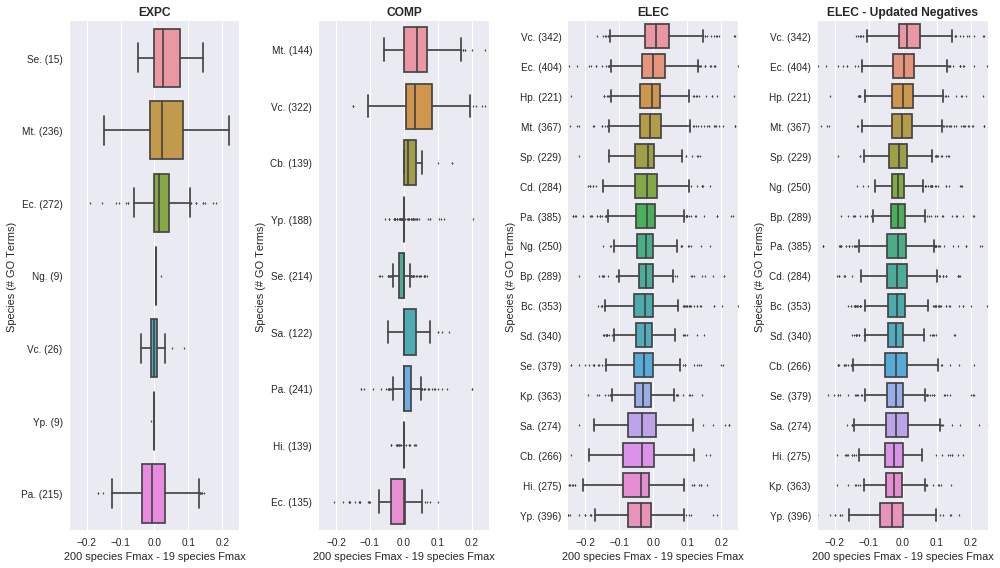

In [129]:
# now make a boxplot of the differences for each taxon
# f, [ax1, ax2, ax3] = plt.subplots(ncols=3)
# f, axes = plt.subplots(ncols=2, figsize=())
titles = {'expc': 'EXPC', 'expc-comp-recov-comp': 'COMP', 'expc-comp-recov-iea': 'ELEC', 'rem-neg-iea-recov-iea': 'ELEC - Updated Negatives'}
nplots = 4
f, axes = plt.subplots(ncols=nplots, figsize=(3.5*nplots,8))
for i, (eval_ev_codes, taxon_diffs) in enumerate(sorted(fmax_diff.items())):
    if i >= nplots: 
        continue
    df_diff = pd.concat(taxon_diffs.values())
    df_diff.reset_index(inplace=True)
    df_diff, order = add_species_names(df_diff)
    
    boxplot(df_diff, titles[eval_ev_codes], axes[i])
    
plt.tight_layout()
out_file = "outputs/viz/eval-loso/fmax-diff-200-19-4.pdf"
print("%s" % (out_file))
plt.savefig(out_file)
plt.show()
plt.close()

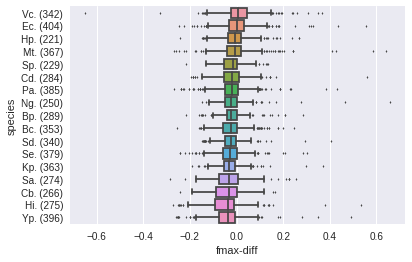

In [96]:
# make three boxplots, for EXPC, COMP and ELEC



In [63]:
df_diff['#taxon'] = df_diff['#taxon'].astype('category')

In [64]:
df_diff.describe()

,fmax,avgp,auprc,auroc,# test ann,fmax-diff
count,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000
mean,0.745392,0.695956,0.709914,0.896547,81.204447,-0.013303
std,0.187358,0.218084,0.215358,0.107594,125.214498,0.067097
min,0.012600,0.003400,0.022400,0.268900,10.000000,-0.269600
25%,0.657000,0.577700,0.596500,0.850700,19.000000,-0.046100
50%,0.781200,0.736700,0.748900,0.926300,35.000000,-0.015000
75%,0.884600,0.862100,0.878000,0.979700,75.000000,0.019300
max,1.000000,1.000000,1.000000,1.000000,1077.000000,0.571600


# plot s200 
## Boxplots together

('2018_09-s200-seq-sim-e0_1', 'expc-comp-rem-neg-iea', 'comp', '', 'bp')
('2018_09-s200-seq-sim-e0_1', 'expc-comp-rem-neg-iea', 'iea', '', 'bp')
writing to outputs/viz/eval-loso/expc-comp-rem-neg-iea-iea/2018_09-s200-seq-sim-e0_1/../s200-eval-comp-iea-fmax-boxplots-bp-0_95.pdf


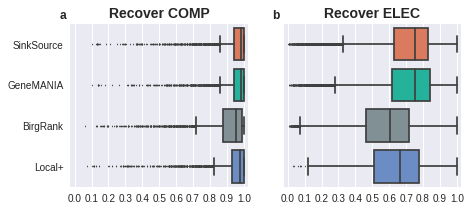

In [268]:
# code for generating boxplots comparing the median f-max of the different algorithms on different networks for the paper
version_name = {"2018_06-seq-sim-e1e-25": r"SSN $1 \times{}10^{-25}$", "2018_06-seq-sim-e0_1": "SSN 0.1",
               "2018_06-seq-sim-e1e-25-string": r"SSN $1 \times{}10^{-25}$ + STRING",  "2018_06-seq-sim-e0_1-string": "SSN 0.1 + STRING"}
curr_h = 'bp'
# curr_h = 'mf'
eval_name = {"comp": "COMP", "iea": "ELEC"}

# ev_code = "expc-rem-neg-comp-iea"
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
# letters = [['A', 'B'], ['C', 'D'], ['E', 'F'], ['G', 'H']]
# use this cell for creating the plots
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True,
                        figsize=(7,3))
# fig, axes = plt.subplots(nrows=len(plot_loc), ncols=2, sharey=True, sharex=True,figsize=(8,6))
i = 0
for version, ev_codes, eval_ev_codes, keep_ann, h in sorted(ev_code_results):
    if h != curr_h:
        continue
    print(version, ev_codes, eval_ev_codes, keep_ann, h)
    
    cutoffs_data, out_dir = ev_code_results[(version, ev_codes, eval_ev_codes, keep_ann, h)]
    df_curr, _, _, _ = cutoffs_data[0]
#     i = 0 if "e1e-25" in version == "2018_06-seq-sim-e1e-25" else 1
#     i = plot_loc[version]
#     j = 0 if h == 'bp' else 1
#     ax = axes[i][j]
    ax = axes[i]
    measure = measures[0]
    title = "Recover %s" % (eval_name[eval_ev_codes])
#     print(title)
    overview_plots(df_curr, measure, title=title,
                   xlabel=r'F$_{\mathrm{max}}$' if i == len(plot_loc)-1 else '', 
                   out_pref=None, ax=ax)
    ax.text(-0.09, -.7, letters[i], horizontalalignment='left', verticalalignment='center', fontsize=12, weight="bold")
    i += 1

ticks = np.arange(0,1.01,.1)
# ax.set_xticks(ticks, ["%0.1f"%x for x in ticks])
plt.setp(axes, xticks=ticks, xticklabels=["%0.1f"%x for x in ticks])
# plt.show()
# print(out_dir)
# the current dir has the version name
out_file = "%s/../s200-eval-comp-iea-fmax-boxplots-%s-%s.pdf" % (out_dir, curr_h, ss_alpha)
print("writing to %s" % (out_file))
plt.savefig(out_file)
plt.show()
plt.close()